In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [14]:
# Đường dẫn tới thư mục dữ liệu
base_dir = r'C:\\DL\\NDKM\\aug_data'

# Các tham số
IMG_SIZE = (224, 224)  # Kích thước ảnh đầu vào (có thể thay đổi theo mô hình)
BATCH_SIZE = 32
NUM_CLASSES = 10  # Số lớp dữ liệu (danh sách class_names)

# Tạo Data Generators cho huấn luyện và kiểm tra
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,        # Xoay ngẫu nhiên
    shear_range=0.2,          # Biến dạng
    zoom_range=0.2,           # Phóng to/thu nhỏ
    fill_mode='nearest'       # Điền các pixel trống
)


In [16]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 10144 images belonging to 10 classes.
Found 2536 images belonging to 10 classes.


In [17]:
# Tải mô hình pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 [==============================] - 2s 0us/step


In [18]:
# Đóng băng các tầng trong base_model
base_model.trainable = False

In [19]:
# Thêm các tầng trên cùng cho bài toán của bạn
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [20]:
# Định nghĩa mô hình
model = Model(inputs=base_model.input, outputs=predictions)
# Compile mô hình
optimizer = Adam(learning_rate=0.0001)  # Giảm learning rate
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# Các callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [22]:
# Huấn luyện mô hình
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
317/317 [==============================] - 272s 846ms/step - loss: 2.1592 - accuracy: 0.2476 - val_loss: 2.1503 - val_accuracy: 0.2271 - lr: 1.0000e-04
Epoch 2/20
317/317 [==============================] - 258s 814ms/step - loss: 1.7517 - accuracy: 0.4065 - val_loss: 2.0323 - val_accuracy: 0.2819 - lr: 1.0000e-04
Epoch 3/20
317/317 [==============================] - 268s 845ms/step - loss: 1.5253 - accuracy: 0.4885 - val_loss: 1.9700 - val_accuracy: 0.3277 - lr: 1.0000e-04
Epoch 4/20
317/317 [==============================] - 249s 787ms/step - loss: 1.3518 - accuracy: 0.5525 - val_loss: 1.9645 - val_accuracy: 0.3336 - lr: 1.0000e-04
Epoch 5/20
317/317 [==============================] - 249s 785ms/step - loss: 1.2405 - accuracy: 0.5922 - val_loss: 1.9530 - val_accuracy: 0.3525 - lr: 1.0000e-04
Epoch 6/20
317/317 [==============================] - 248s 782ms/step - loss: 1.1283 - accuracy: 0.6264 - val_loss: 1.9500 - val_accuracy: 0.3454 - lr: 1.0000e-04
Epoch 7/20
317/317 [==

In [23]:
model.save('face_recognition_model_0.h5')


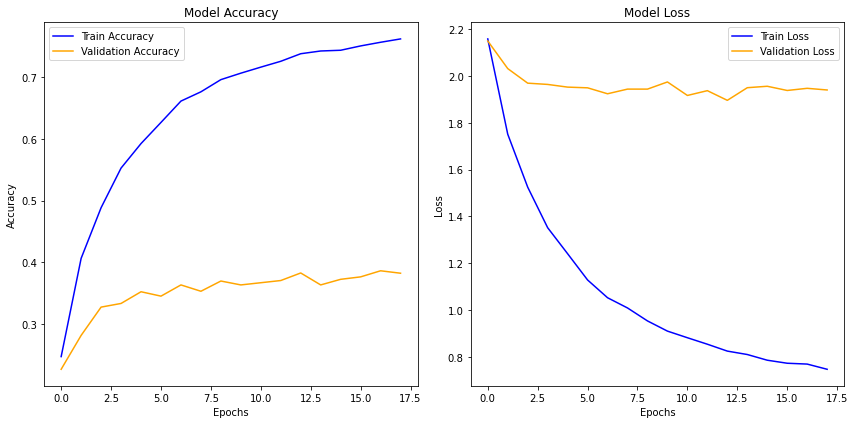

In [24]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ tổn thất
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
